# Step 1: Prepare (images, label) split for train, test, validation sets

In [1]:
import numpy as np
import pandas as pd

In [2]:
# read data from csv file
def get_data(file):
    data = pd.read_csv(file)
    data = data.to_numpy()
    labels = []
    images = []
    
    for row_ind in range(data.shape[0]):
        labels.append(data[row_ind, 0])
        images.append(data[row_ind, 1:])
        
    images = np.reshape(images, newshape=(-1, 28, 28))
    labels = np.array(labels)
    return images, labels

X_train, y_train = get_data('../input/Kannada-MNIST/train.csv')
X_val, y_val = get_data('../input/Kannada-MNIST/Dig-MNIST.csv')
X_test, test_Id = get_data('../input/Kannada-MNIST/test.csv')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(60000, 28, 28)
(60000,)
(5000, 28, 28)


In [3]:
pd.Series(y_val).value_counts()

7    1024
6    1024
5    1024
4    1024
3    1024
2    1024
9    1024
1    1024
8    1024
0    1024
dtype: int64

Evenly distributed, non-skewed classes

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), test_size=0.1, random_state=42, shuffle=True)

9


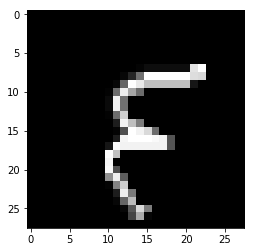

In [5]:
# visualization of one random data sample
from PIL import Image
import matplotlib.pyplot as plt
imgplot = plt.imshow(X_train[24], cmap='gray')
print(y_train[24])

# Step 2: One-hot encoder and ImageDataGenerator for image augmentation

In [6]:
# use one-hot encoder for multi-class classification
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

Using TensorFlow backend.


In [7]:
# add another dimension to the data since they are gray scale images
X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [8]:
# Create an ImageDataGenerator and do image augmentation to avoid overfitting
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    height_shift_range=0.1,
    width_shift_range=0.15,
    zoom_range=0.1,
    rotation_range=10
    )

print(X_train.shape)
print(X_val.shape)

(63216, 28, 28, 1)
(7024, 28, 28, 1)


# Step 3: Define simple CNN baseline model

In [9]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [10]:
import keras
from keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Model

inputs = Input(shape=(28, 28, 1))

x = Conv2D(32, (5, 5), padding='same')(inputs)
x = LeakyReLU()(x)
x = Conv2D(32, (5, 5), padding='same')(x)
x = LeakyReLU()(x)

x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (4, 4), padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(64, (4, 4), padding='same')(x)
x = LeakyReLU()(x)

x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = LeakyReLU()(x)

# from flattened feature representation to categorical prob
x = GlobalAveragePooling2D()(x)
pred = keras.layers.Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=pred)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        3283

In [11]:
from keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)

# Compile Model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

from tensorflow.keras.callbacks import EarlyStopping
# setup callbacks for auto earlystopping
es = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=10, verbose=1, mode='auto', restore_best_weights=True)

# Train the Model
batch_size = 1024
epochs = 50
history = model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=batch_size), 
                              epochs=epochs,
                              steps_per_epoch=X_train.shape[0]//batch_size,
                              validation_data=(X_val, y_val),
                              callbacks=[es],
                              verbose=1)

Epoch 1/50
61/61 [==============================] - 18s 293ms/step - loss: 2.1826 - acc: 0.1826 - val_loss: 64.3711 - val_acc: 0.3929
Epoch 2/50
61/61 [==============================] - 16s 267ms/step - loss: 1.3478 - acc: 0.5914 - val_loss: 81.3824 - val_acc: 0.7373
Epoch 3/50
61/61 [==============================] - 15s 242ms/step - loss: 0.9192 - acc: 0.7375 - val_loss: 65.4946 - val_acc: 0.8265
Epoch 4/50
61/61 [==============================] - 16s 258ms/step - loss: 0.6941 - acc: 0.8030 - val_loss: 58.2323 - val_acc: 0.8494
Epoch 5/50
61/61 [==============================] - 15s 248ms/step - loss: 0.5948 - acc: 0.8303 - val_loss: 52.0714 - val_acc: 0.8828
Epoch 6/50
61/61 [==============================] - 17s 277ms/step - loss: 0.5071 - acc: 0.8575 - val_loss: 47.3891 - val_acc: 0.8898
Epoch 7/50
61/61 [==============================] - 15s 252ms/step - loss: 0.4461 - acc: 0.8757 - val_loss: 40.4452 - val_acc: 0.9080
Epoch 8/50
61/61 [==============================] - 16s 256ms/

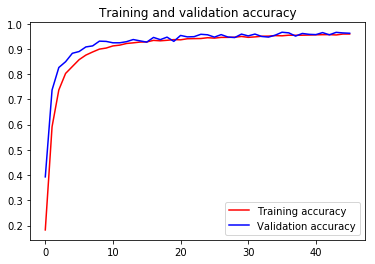

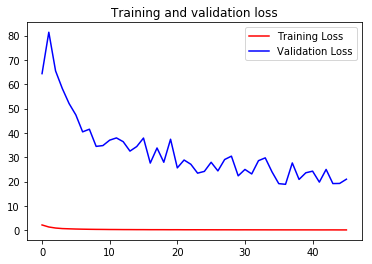

In [12]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# creates a new figure
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Step 4: Error analysis

In [13]:
# confusion matrix for validation data
from sklearn.metrics import confusion_matrix
val_prediction = model.predict(X_val)
val_prediction = np.argmax(val_prediction, axis=1)

val_truth = np.argmax(y_val,axis=1)
conf = confusion_matrix(val_truth, val_prediction)
conf = pd.DataFrame(conf, index=range(0,10), columns=range(0,10))
from IPython.display import display
display(conf)

,0,1,2,3,4,5,6,7,8,9
0,625,16,3,5,5,1,2,2,8,12
1,4,722,1,0,1,1,0,1,2,1
2,5,1,707,4,0,0,0,4,4,1
3,1,0,2,695,6,3,1,14,0,0
4,1,1,2,3,724,4,1,1,1,4
5,0,1,1,14,8,674,0,0,1,0
6,0,0,0,1,3,0,687,11,0,7
7,1,0,1,3,2,0,24,640,0,1
8,2,1,0,0,1,0,3,0,669,6
9,1,2,0,0,1,0,12,0,0,644


Most of the wrong prediction comes from the fact that some of the true 1s are predicted to be 0s, this is understandable as it can be seen from image below, 1 and 0 are rather similar, with little distortion, it can be hard to tell between them.

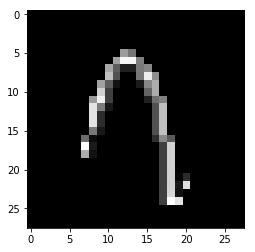

In [14]:
y_train_numeric = np.argmax(y_train, axis=1)
# 1 
for i in range(y_train_numeric.shape[0]):
    if y_train_numeric[i] == 1:
        imgplot = plt.imshow(np.squeeze(X_train[i]), cmap='gray')

In [ ]:
# 0
for i in range(y_train_numeric.shape[0]):
    if y_train_numeric[i] == 0:
        imgplot = plt.imshow(np.squeeze(X_train[i]), cmap='gray')

Further improvements can be done by using ensemble of models, which focuses on the digits that are being weakly classified by previous model like in the case of 0 and 1, one can then train a classifier explicitly tuned for 0 and 1 cases and use its prediction instead when the softmax prob provided by previous model between 0 and 1 are very close and they are the top 2 most likely classes for that image classification sample.

In [15]:
# generate prediction for test set
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1)
submission_df = pd.DataFrame({'id':test_Id , 'label':prediction.astype(np.int32)})
# for kernel based competition
submission_df.to_csv('./submission.csv', index=False)